# **THESEUS**
## **INFERENCE**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import os
import gc
import time
from IPython.display import Markdown


# **CONFIGURATION**

In [2]:
ROOT            = "/kaggle/input/home-credit-credit-risk-model-stability"

In [3]:

CONFIG_LIBRARY={

    1 :  {    "id": 1,
    "type":"LGBMClassifier",
    "parent": 0, # 0 means metamodel
    "children": None, 
    "parameters" : {},
    "make_data_func": "make_data_for_model1",
    "fit_func": "kfold_lightgbm_sklearn"
    
    
},
    
    2: {
    "id": 2,
    "type":"Tensorflow",
    "parent": 0,
    "children" : None,
    "parameters" : {},
    "make_data_func": "make_data_for_model2",
    "fit_func": "kfold_tensorflow"
}
,
       3: {
    "id": 3,
    "type":"CatBoost",
    "parent": 0,
    "children" : None,
    "parameters" : {},
    "make_data_func": "make_data_for_model3",
    "fit_func": "kfold_catboost_sklearn"
}
,
    
  
    
    0: {
    "id": 0,
    "type" : "Ensemble (LGBMClassifier, Tensorflow, CatBoost)",
    "parent": None,
    "children" : [1,2,3],
    "parameters" : {},
    "make_data_func": "prepare_for_metamodel",
    "fit_func": "simple_average"
    
},
    
    
    
}
    


In [4]:
class Model:
    def __init__ (self, init_id):
        
        if init_id==0:
            print("MODEL ", init_id, " is being initialized")
        else:
            print("\tMODEL ", init_id, " is being initialized")
        if init_id not in CONFIG_LIBRARY:
            raise ValueError("Invalid input Type - class Model initialization")
        
          
        self.definition=CONFIG_LIBRARY[init_id]    

        self.state=0 
        # 0=initialized
        # 1,  for base models: fitted; for ensembles: created oof predictions
       
        self.id=init_id
        self.model_children=[]
        
        if self.definition['children'] is not None:
            print("model ", init_id, " has children ",self.definition['children'])
            for i in self.definition['children']:
             
                if i not in CONFIG_LIBRARY:
                    raise ValueError("Invalid input Type - class Model initialization")
                
                self.model_children.append(Model(i))
                
        if init_id==0:
            print("MODEL ", init_id, " has been initialized")      
        else:
            print("\tMODEL ", init_id, " has been initialized")     
       
        
        
    def train(self):

        variable = "Function train has started - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        if self.model_children:
            for child in self.model_children:
                child.train()
            print("All submodels of model ", self.id, " have been trained")
        
       
        self.path_input=self.make_data()
        self.fit(self.path_input)
        self.path_output=self.make_prediction(self.path_input)
        
        
        
        variable = "Function train has finished - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        
    def make_data(self):
        variable = "Function make_data has started - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        func = globals().get(self.definition["make_data_func"])
        if func is not None and callable(func):
            
            path=func()
        else:
            raise ValueError("Invalid input Type - make data function")
            
        
        variable = "Function make_data has finished - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        return path
    
    
    def fit(self, path):
        
        
        
        variable = "Function fit has started - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        func = globals().get(self.definition["fit_func"])
        if func is not None and callable(func):
            self.estimators=[]
            #self.estimators
            self.model, self.oof_preds=func(path)
            
            
            
        else:
            raise ValueError("Invalid input Type - fit function") 

     
            
       
        variable = "Function fit has finished - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        
        
    def make_prediction(self, path):
        
        
        variable = "Function make_prediction has started - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        data = pd.read_parquet(path) 
        for col in data.select_dtypes(exclude=['number','bool']).columns:
            data[col] = data[col].astype('category')
        data_target = data[['case_id', 'WEEK_NUM', 'target']]
        data.drop(data[data['target'].notnull()].index, inplace=True)
        case_ids=data['case_id'].copy()
        data.drop(columns=['case_id', 'WEEK_NUM', 'target'], inplace=True)
        print(self.model.predict_proba(data)[:,1].shape)
        y_preds=pd.Series(self.model.predict_proba(data)[:,1], index=case_ids)
        
        print(y_preds.head())
        
        #oof_preds_df=pd.DataFrame({str("model"+str(self.id)): y_preds})
        
        output = pd.DataFrame({str("preds"): y_preds.values, 'case_id': case_ids.values})
        
        concatenated_df = pd.concat([self.oof_preds, output], axis=0)
        merged_df = pd.merge(concatenated_df, data_target, on="case_id")
        print("oof_preds shape", self.oof_preds.shape)
        print("output shape", output.shape)
        print("concatenated_dfshape", concatenated_df.shape)
        print("merged shape", merged_df.shape)
        
  
        
        print(output.head())
        path_output=str("/kaggle/working/output"+str(self.id)+".parquet")
        merged_df.to_parquet(path_output)
        
        print("Gini stability - model ", self.id, "is ", gini_stability(path_output))
        
        if self.id==0:
        
            df_subm = pd.read_csv(str(ROOT + "/sample_submission.csv"))
            df_merged = pd.merge(df_subm, output[['preds', 'case_id']], on='case_id', how='left')
            df_merged.drop('score', axis=1, inplace=True)
            df_merged.rename(columns={'preds': 'score'}, inplace=True)
            

        
            
           
         
            df_merged.to_csv("submission.csv")
            
            
            
        variable = "Function make_prediction has finished - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        
        return path_output
        
    
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
        
        '''
    def predict(self):
        
    
        
    def set_oof_predictions(self, series):
        
    def get_oof_predictions(self, series):
        
    def stack(self):
    '''
    


## Initialization

In [5]:
def initialization():
    
    display(Markdown("## **function initialization has started**"))
    if not check_validity():
        raise ValueError("Invalid input Type - model configuration")
    metamodel=Model(0)
   
    display(Markdown("## **function initialization has successfully finished**"))
    print()
 
    return metamodel

In [6]:
from contextlib import contextmanager
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

## **CUSTOM FUNCTIONS**

## make_data_for_model1()

In [7]:
def make_data_for_model1():
    print("make_data_for_model1 started")
    data=pd.read_parquet("/kaggle/input/home-credit-2024-additional-dataset/processed_004_PCA300.parquet")
    data=data[1520000:]
    #print("shape ", data.shape)
    
    target_counts = data['target'].value_counts(dropna=False)
    
# Print the counts
    #print("Counts of values in 'target' column:")
    #print(target_counts)
  
    
    '''
    
        # Check if 'case_id' column exists and print unique values and range
    if 'case_id' in data.columns:
        print("case_id column exists")
        if data['case_id'].is_unique:
            print("All values of case_id are unique")
        else:
            print("Values of case_id are not unique")
        print("Range of values of case_id:", data['case_id'].min(), "to", data['case_id'].max())
    else:
        print("case_id column does not exist")
    
    # Check if 'target' column exists and its values are 0, 1, or NaN, and count each
    if 'target' in data.columns:
        print("\ntarget column exists")
        print("Value counts of target column:")
        print(data['target'].value_counts(dropna=False))
    else:
        print("\ntarget column does not exist")
    
    # Check the range of values in the 'WEEK_NUM' column
    if 'WEEK_NUM' in data.columns:
        print("\nWEEK_NUM column exists")
        print("Range of values of WEEK_NUM:", data['WEEK_NUM'].min(), "to", data['WEEK_NUM'].max())
    else:
        print("\nWEEK_NUM column does not exist")
    
    # Calculate the percentage of NaN values in the DataFrame excluding 'target', 'case_id', and 'WEEK_NUM' columns
    nan_percentage = (data.drop(columns=['target', 'case_id', 'WEEK_NUM']).isna().sum().sum() / 
                      (data.shape[0] * (data.shape[1] - 3))) * 100
    print("\nPercentage of NaN values in DataFrame (excluding target, case_id, WEEK_NUM): {:.2f}%".format(nan_percentage))
    '''
    path = "/kaggle/working/input1.parquet"
    # Export DataFrame to Parquet
    
    if all(col in data.columns for col in ['target', 'case_id', 'WEEK_NUM']):
        # Check if target column values are restricted to 1, 0, or NaN
        

        # Check if case_id has unique values
        case_id_unique = data['case_id'].is_unique

        # Check if case_id and WEEK_NUM don't contain NaN values
        case_id_week_num_no_nan = data[['case_id', 'WEEK_NUM']].notna().all().all()

        # If all conditions are met, print the statement
        if case_id_unique and case_id_week_num_no_nan:
            print("target, case_id, and WEEK_NUM are present and properly formatted")
        else:
            print("Conditions are not met.")
        
          
    else:
        print("Columns target, case_id, or WEEK_NUM are missing.")
        
        
    if 'target' in data.columns:
    # Print the value counts of 'target' column, including NaN values
        print(data['target'].value_counts(dropna=False))
    else:
        print("Column 'target' is missing.")
        
    columns_to_exclude = ['target', 'case_id', 'WEEK_NUM']

# Filter out the columns to count
    columns_to_count = [col for col in data.columns if col not in columns_to_exclude]

    # Count the remaining columns
    column_count = len(columns_to_count)

    # Print the count
    print("Number of columns (excluding 'target', 'case_id', and 'WEEK_NUM'): ", column_count)
    
    row_count = data.shape[0]

# Print the count
    print("Number of rows:", row_count)
    
    data.to_parquet(path)
    
    print("make_data_for_model1 ended")
    return path
    
    
    
    
    
    
    
    
    

## make_data_for_model2()

In [8]:
def make_data_for_model2():
    
    print("make_data_for_model2 started")
    data=pd.read_parquet("/kaggle/input/home-credit-2024-additional-dataset/processed_004_PCA300.parquet")
    data=data[1520000:]
    #print("shape ", data.shape)
    
    target_counts = data['target'].value_counts(dropna=False)
    
# Print the counts
    #print("Counts of values in 'target' column:")
    #print(target_counts)
  
    
    '''
    
        # Check if 'case_id' column exists and print unique values and range
    if 'case_id' in data.columns:
        print("case_id column exists")
        if data['case_id'].is_unique:
            print("All values of case_id are unique")
        else:
            print("Values of case_id are not unique")
        print("Range of values of case_id:", data['case_id'].min(), "to", data['case_id'].max())
    else:
        print("case_id column does not exist")
    
    # Check if 'target' column exists and its values are 0, 1, or NaN, and count each
    if 'target' in data.columns:
        print("\ntarget column exists")
        print("Value counts of target column:")
        print(data['target'].value_counts(dropna=False))
    else:
        print("\ntarget column does not exist")
    
    # Check the range of values in the 'WEEK_NUM' column
    if 'WEEK_NUM' in data.columns:
        print("\nWEEK_NUM column exists")
        print("Range of values of WEEK_NUM:", data['WEEK_NUM'].min(), "to", data['WEEK_NUM'].max())
    else:
        print("\nWEEK_NUM column does not exist")
    
    # Calculate the percentage of NaN values in the DataFrame excluding 'target', 'case_id', and 'WEEK_NUM' columns
    nan_percentage = (data.drop(columns=['target', 'case_id', 'WEEK_NUM']).isna().sum().sum() / 
                      (data.shape[0] * (data.shape[1] - 3))) * 100
    print("\nPercentage of NaN values in DataFrame (excluding target, case_id, WEEK_NUM): {:.2f}%".format(nan_percentage))
    '''
    path = "/kaggle/working/input2.parquet"
    
    
    
    if all(col in data.columns for col in ['target', 'case_id', 'WEEK_NUM']):
        # Check if target column values are restricted to 1, 0, or NaN
        

        # Check if case_id has unique values
        case_id_unique = data['case_id'].is_unique

        # Check if case_id and WEEK_NUM don't contain NaN values
        case_id_week_num_no_nan = data[['case_id', 'WEEK_NUM']].notna().all().all()

        # If all conditions are met, print the statement
        if case_id_unique and case_id_week_num_no_nan:
            print("target, case_id, and WEEK_NUM are present and properly formatted")
        else:
            print("Conditions are not met.")
        
          
    else:
        print("Columns target, case_id, or WEEK_NUM are missing.")
        
        
    if 'target' in data.columns:
    # Print the value counts of 'target' column, including NaN values
        print(data['target'].value_counts(dropna=False))
    else:
        print("Column 'target' is missing.")
        
    columns_to_exclude = ['target', 'case_id', 'WEEK_NUM']

# Filter out the columns to count
    columns_to_count = [col for col in data.columns if col not in columns_to_exclude]

    # Count the remaining columns
    column_count = len(columns_to_count)

    # Print the count
    print("Number of columns (excluding 'target', 'case_id', and 'WEEK_NUM'): ", column_count)
    
    row_count = data.shape[0]

# Print the count
    print("Number of rows:", row_count)
    # Export DataFrame to Parquet
    data.to_parquet(path)
    
    print("make_data_for_model2 ended")
    return path

## make_data_for_model3()

In [9]:
def make_data_for_model3():
    
    #print("make_data_for_model3 started")
    data=pd.read_parquet("/kaggle/input/home-credit-2024-additional-dataset/processed_004_PCA300.parquet")
    data=data[1520000:]
    #print("shape ", data.shape)
    
    target_counts = data['target'].value_counts(dropna=False)
    
# Print the counts
    #print("Counts of values in 'target' column:")
    #print(target_counts)
  
    
    '''
    
        # Check if 'case_id' column exists and print unique values and range
    if 'case_id' in data.columns:
        print("case_id column exists")
        if data['case_id'].is_unique:
            print("All values of case_id are unique")
        else:
            print("Values of case_id are not unique")
        print("Range of values of case_id:", data['case_id'].min(), "to", data['case_id'].max())
    else:
        print("case_id column does not exist")
    
    # Check if 'target' column exists and its values are 0, 1, or NaN, and count each
    if 'target' in data.columns:
        print("\ntarget column exists")
        print("Value counts of target column:")
        print(data['target'].value_counts(dropna=False))
    else:
        print("\ntarget column does not exist")
    
    # Check the range of values in the 'WEEK_NUM' column
    if 'WEEK_NUM' in data.columns:
        print("\nWEEK_NUM column exists")
        print("Range of values of WEEK_NUM:", data['WEEK_NUM'].min(), "to", data['WEEK_NUM'].max())
    else:
        print("\nWEEK_NUM column does not exist")
    
    # Calculate the percentage of NaN values in the DataFrame excluding 'target', 'case_id', and 'WEEK_NUM' columns
    nan_percentage = (data.drop(columns=['target', 'case_id', 'WEEK_NUM']).isna().sum().sum() / 
                      (data.shape[0] * (data.shape[1] - 3))) * 100
    print("\nPercentage of NaN values in DataFrame (excluding target, case_id, WEEK_NUM): {:.2f}%".format(nan_percentage))
    '''
    path = "/kaggle/working/input3.parquet"
    
    
    if all(col in data.columns for col in ['target', 'case_id', 'WEEK_NUM']):
        # Check if target column values are restricted to 1, 0, or NaN
        

        # Check if case_id has unique values
        case_id_unique = data['case_id'].is_unique

        # Check if case_id and WEEK_NUM don't contain NaN values
        case_id_week_num_no_nan = data[['case_id', 'WEEK_NUM']].notna().all().all()

        # If all conditions are met, print the statement
        if case_id_unique and case_id_week_num_no_nan:
            print("target, case_id, and WEEK_NUM are present and properly formatted")
        else:
            print("Conditions are not met.")
        
          
    else:
        print("Columns target, case_id, or WEEK_NUM are missing.")
        
        
    if 'target' in data.columns:
    # Print the value counts of 'target' column, including NaN values
        print(data['target'].value_counts(dropna=False))
    else:
        print("Column 'target' is missing.")
        
    columns_to_exclude = ['target', 'case_id', 'WEEK_NUM']

# Filter out the columns to count
    columns_to_count = [col for col in data.columns if col not in columns_to_exclude]

    # Count the remaining columns
    column_count = len(columns_to_count)

    # Print the count
    print("Number of columns (excluding 'target', 'case_id', and 'WEEK_NUM'): ", column_count)
    
    row_count = data.shape[0]

# Print the count
    print("Number of rows:", row_count)
    
    # Export DataFrame to Parquet
    data.to_parquet(path)
    
    print("make_data_for_model3 ended")
    return path

## kfold_lightgbm_sklearn()

In [10]:
def kfold_lightgbm_sklearn(path):
    
    
    LIGHTGBM_PARAMS = {
  "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,  
    "learning_rate": 0.05,
    "n_estimators": 2000,  
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
   
  
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64,
    "device": 'cpu', 
    "verbose": -1,
   'deterministic' : True
   

}
    from sklearn.model_selection import KFold, StratifiedKFold
    import lightgbm as lgb
    from sklearn.model_selection import StratifiedGroupKFold
    NUM_FOLDS=5
    RANDOM_SEED=42
    
    df=pd.read_parquet(path)
   
    #time.sleep(30)
    start_time = time.time()
    
  
    df.drop(df[df['target'].isnull()].index, inplace=True)
    #test=data.copy()
    #test.drop(test[test['target'].notnull()].index, inplace=True)
   
    #df=reduce_mem_usage(df)
    #test=reduce_mem_usage(test)
    
  
    #time.sleep(30)
    #print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))
    print("Train/valid shape: {}, ".format(df.shape))
    
    del_features = ['target', 'case_id', 'WEEK_NUM']
    predictors = list(filter(lambda v: v not in del_features, df.columns))

    if not 1:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    weeks = df["WEEK_NUM"]
    cv = StratifiedGroupKFold(n_splits=5, shuffle=False)
    
        # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    
    importance_df = pd.DataFrame()
    eval_results = dict()
    
    fitted_models = []
    n_fold=0
    print("df train shape ", df[predictors].shape)
    print("y shape ", len(df['target']))
    
    '''
    print("Numerical Columns:")
    for col in df[predictors].select_dtypes(include=np.number).columns:
        print(f"{col}: Min={df[predictors][col].min():.2f}, Mean={df[predictors][col].mean():.2f}, Max={df[predictors][col].max():.2f}, Std={df[predictors][col].std():.2f}")

            # Count categories in categorical columns
    print("\nCategorical Columns:")
    for col in df[predictors].select_dtypes(include='category').columns:
        num_categories = df[predictors][col].nunique()
        print(f"{col}: {num_categories} categories")
    
    '''
    
    
    
    with tqdm(total=NUM_FOLDS) as pbar:
        #for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['target'])):
        for train_idx, valid_idx in cv.split(df[predictors], df['target'], groups=weeks):  
          
            train_x, train_y = df[predictors].iloc[train_idx], df['target'].iloc[train_idx]
            valid_x, valid_y = df[predictors].iloc[valid_idx], df['target'].iloc[valid_idx]
            
            train_x.sort_index(axis=1, inplace=True)
            valid_x.sort_index(axis=1, inplace=True)
            # Print statistics for numerical columns
            print()
            #for col in train_x.columns:
             #   print(col)
            print()
                
            print("X_train shape ", train_x.shape)
            print("y_train shape ", len(train_y))
            print("X_valid shape ", valid_x.shape)
            print("y_valid shape ", len(valid_y))
        
            #time.sleep(30)
            params = {'random_state': RANDOM_SEED, 'nthread': 4}
            clf = lgb.LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})


         
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                            callbacks=[lgb.log_evaluation(200), lgb.early_stopping(100)]
                           )
            

            fitted_models.append(clf)

            if 1:
                oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]



                # Feature importance by GAIN and SPLIT

            eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
            eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['auc']

            elapsed_time = time.time() - start_time
            remaining_time = elapsed_time * (NUM_FOLDS - n_fold - 1) / (n_fold + 1)
            print('Fold %2d AUC : %.6f. Elapsed time: %.2f seconds. Remaining time: %.2f seconds.'
                  % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]), elapsed_time, remaining_time))
            

            del clf, train_x, train_y, valid_x, valid_y
            n_fold+=1
            gc.collect()
            pbar.update(1)
            
    print('Full AUC score %.6f' % roc_auc_score(df['target'], oof_preds))
    # Get the average feature importance between folds
    
    plt.figure(figsize=(8, 6))
    plt.hist(oof_preds, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Probability Histogram')
    plt.grid(True)
    plt.show()
    
    
    
    # Save feature importance, test predictions and oof predictions as csv
    
        
        
  
        
        
    model = VotingModel(fitted_models)
    
    
   








    print("oof_preds shape ", pd.Series(oof_preds).shape)
    print("data shape ", df['case_id'].shape)

    # Resetting the index of data['case_id'] to ensure alignment
    data_case_id_reset_index = df['case_id'].reset_index(drop=True)

    oof_df = pd.DataFrame({'preds': pd.Series(oof_preds), 'case_id': data_case_id_reset_index})
    print("shape oof_df is ", oof_df.shape)
    del df; gc.collect()
    return model, oof_df

## kfold_tensorflow(path)

In [11]:
def kfold_tensorflow(path):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    from tensorflow.keras.layers import Dense, Dropout
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from sklearn.metrics import roc_curve, auc
    import tempfile
    NUM_FOLDS=2
    RANDOM_SEED=42
    EARLY_STOPPING = 100
    EPOCHS = 100
    BATCH_SIZE = 2048
    
    mpl.rcParams['figure.figsize'] = (12, 10)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    #data = pd.read_parquet("/kaggle/input/home-credit-2024-additional-dataset/processed_004_PCA300.parquet")
    data = pd.read_parquet(path)        
         
    for col in data.select_dtypes(exclude=['number','bool']).columns:
        data[col] = data[col].astype('category')

    #print(data.dtypes.value_counts())
    #df=reduce_mem_usage(df)
    
    categories = [cat for cat in data.columns if data[cat].dtype == 'category']
    #print("categories")
    #print(categories)
    categories=set(categories) - set(categories[::3])
    
    
    
    
    data.drop(columns=list(categories), inplace=True)
    
    #print("DATAFRAME shape:", data.shape)
    #print(data.dtypes.value_counts())
    #time.sleep(30)
    start_time = time.time()
    
    
    
    numerical_columns = data.select_dtypes(include=['number']).columns

    for column in numerical_columns:
        min_value = data[column].min()
        max_value = data[column].max()
        #print(f"Column: {column}, Min Value: {min_value}, Max Value: {max_value}")
        
    
    
    data.drop(data[data['target'].isnull()].index, inplace=True)
 
    
    
  

 
    
   
    
  
   
    #print("Train/valid shape: {}, ".format(data.shape))
    del_features = ['target', 'case_id', 'WEEK_NUM']
    predictors = list(filter(lambda v: v not in del_features, data.columns))

    if not 1:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    
        # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(data.shape[0])
    
    importance_df = pd.DataFrame()
    eval_results = dict()
    
    fitted_models = []
    
    METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      #keras.metrics.MeanSquaredError(name='Brier score'),
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

    def make_model(metrics=METRICS, output_bias=None):
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)
        model = keras.Sequential([
          keras.layers.Dense(
              16, activation='relu',
              input_shape=(len(predictors),)),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation='sigmoid',
                             bias_initializer=output_bias),
        ])

        model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=1e-3),
          loss=keras.losses.BinaryCrossentropy(),
          metrics=metrics)

        return model
    
    
    def plot_metrics(history):
                metrics = ['loss', 'prc', 'precision', 'recall']
                for n, metric in enumerate(metrics):
                    name = metric.replace("_"," ").capitalize()
                    plt.subplot(2,2,n+1)
                    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
                    plt.plot(history.epoch, history.history['val_'+metric],
                             color=colors[0], linestyle="--", label='Val')
                    plt.xlabel('Epoch')
                    plt.ylabel(name)
                if metric == 'loss':
                    plt.ylim([0, plt.ylim()[1]])
                elif metric == 'auc':
                    plt.ylim([0.8,1])
                else:
                    plt.ylim([0,1])

                plt.legend()
                plt.show()
    
    
    def plot_loss(history, label, n):
                  # Use a log scale on y-axis to show the wide range of values.
                plt.semilogy(history.epoch, history.history['loss'],
                               color=colors[n], label='Train ' + label)
                plt.semilogy(history.epoch, history.history['val_loss'],
                               color=colors[n], label='Val ' + label,
                               linestyle="--")
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.show()
    
    
    def plot_cm(labels, predictions, threshold=0.5):
                cm = confusion_matrix(labels, predictions > threshold)
                plt.figure(figsize=(5,5))
                sns.heatmap(cm, annot=True, fmt="d")
                plt.title('Confusion matrix @{:.2f}'.format(threshold))
                plt.ylabel('Actual label')
                plt.xlabel('Predicted label')
                plt.show()

                print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
                print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
                print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
                print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
                print('Total Fraudulent Transactions: ', np.sum(cm[1]))
                
    def plot_roc(name, labels, predictions, **kwargs):
                fp, tp, _ = roc_curve(labels, predictions)

                plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
                plt.xlabel('False positives [%]')
                plt.ylabel('True positives [%]')
                plt.xlim([-0.5,20])
                plt.ylim([80,100.5])
                plt.grid(True)
                ax = plt.gca()
                ax.set_aspect('equal')
                plt.show()
                
                
    data_target=data[['target']].copy()           
    case_ids=data[['case_id']].copy()
    
    print("first for loop")
    with tqdm(total=NUM_FOLDS) as pbar:
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(np.zeros(len(data_target)), data_target['target'])):
            #data[predictors].iloc[train_idx].to_parquet("/kaggle/working/train_x"+str(n_fold)+".parquet")
            #data[['target']].iloc[train_idx].to_parquet("/kaggle/working/train_y"+str(n_fold)+".parquet")
            data[predictors].iloc[valid_idx].to_parquet("/kaggle/working/valid_x"+str(n_fold)+".parquet")
            data[['target']].iloc[valid_idx].to_parquet("/kaggle/working/valid_y"+str(n_fold)+".parquet")
            #print('valid_idx[:5] ', valid_idx[:5])
            print(len(valid_idx))
            
            pbar.update(1)
    del data;gc.collect()
    print("second for loop")
    
    tf.get_logger().setLevel('INFO')
   
    with tqdm(total=NUM_FOLDS) as pbar:
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(np.zeros(len(data_target)), data_target['target'])):
            print("FOLD ", n_fold)
            train_x= np.empty((0,))
            train_y= np.empty((0,))
            for fold in range(NUM_FOLDS):
                if fold!=n_fold:
                    if np.array_equal(train_x, np.empty((0,))):
                        print("here ",fold)
                        train_x=np.asarray(pd.read_parquet("/kaggle/working/valid_x"+str(fold)+".parquet").sort_index(axis=1).values).astype('float32')
                        train_y=np.asarray(pd.read_parquet("/kaggle/working/valid_y"+str(fold)+".parquet")['target'].values).astype('float32').reshape(-1, 1)
                    else:
                        print("here2 ", fold)
                        train_x=np.vstack((train_x, np.asarray(pd.read_parquet("/kaggle/working/valid_x"+str(fold)+".parquet").sort_index(axis=1).values).astype('float32')))
                        train_y=np.vstack((train_y, np.asarray(pd.read_parquet("/kaggle/working/valid_y"+str(fold)+".parquet")['target'].values).astype('float32').reshape(-1, 1)))
                    print("length ", train_x.shape, train_y.shape)
                
            print("train_x shape: ", train_x.shape)
            print("train_y shape: ", train_y.shape)
                        
            #train_x, train_y = np.asarray(pd.read_parquet("/kaggle/working/train_x"+str(n_fold)+".parquet").values).astype('float32'), np.asarray(pd.read_parquet("/kaggle/working/train_y"+str(n_fold)+".parquet")['target'].values).astype('float32').reshape(-1, 1)
            valid_x, valid_y = np.asarray(pd.read_parquet("/kaggle/working/valid_x"+str(n_fold)+".parquet").sort_index(axis=1).values).astype('float32'), np.asarray(pd.read_parquet("/kaggle/working/valid_y"+str(n_fold)+".parquet")['target'].values).astype('float32').reshape(-1, 1)
            
            
            print("valid_x shape: ", valid_x.shape)
            print("valid_y shape: ", valid_y.shape)
           
            
            
       
            
            
            
            
            
            
            
            
            
            
            
            print("Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.")
            
            

            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_prc', 
                verbose=1,
                patience=10,
                mode='max',
                restore_best_weights=True)
            
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 1")
            model = make_model()
            print(model.summary())
            
            model.predict(train_x[:10])
           
        
        
        
            
            print("Optional: Set the correct initial bias.These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see A Recipe for Training Neural Networks: init well. This can help with initial convergence.With the default bias initialization the loss should be about math.log(2) = 0.69314")
            results = model.evaluate(train_x, train_y, batch_size=BATCH_SIZE, verbose=0)
            print("Loss: {:0.4f}".format(results[0]))
            del model;gc.collect
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 2")
            initial_bias = np.log([(1/31)])
            
            model = make_model(output_bias=initial_bias)
            model.predict(train_x[:10])
            
            results = model.evaluate(train_x, train_y, batch_size=BATCH_SIZE, verbose=0)
            print("Loss: {:0.4f}".format(results[0]))
            
            
            
            initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights.weights.h5')
            model.save_weights(initial_weights)
            
            
            del model;gc.collect
            
            
            print()
            print()
            print()
            print()
            print()
            print()
            
            
            '''
            print("MODEL 3")
            
            model = make_model()
            model.load_weights(initial_weights)
            model.layers[-1].bias.assign([0.0])
            zero_bias_history = model.fit(
                train_x,
                train_y,
                batch_size=BATCH_SIZE,
                epochs=20,
                validation_data=(valid_x, valid_y), 
                verbose=0)
            
            
            del model;gc.collect
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 4")
            
            model = make_model()
            model.load_weights(initial_weights)
            careful_bias_history = model.fit(
                train_x,
                train_y,
                batch_size=BATCH_SIZE,
                epochs=20,
                validation_data=(valid_x, valid_y), 
                verbose=0)
            
           
            
            
            
            plot_loss(zero_bias_history, "Zero Bias", 0)
            plot_loss(careful_bias_history, "Careful Bias", 1)
            
            del model;gc.collect
            '''
            
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 5")
            
            model = make_model()
            model.load_weights(initial_weights)
            baseline_history = model.fit(
                train_x,
                train_y,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                #callbacks=[early_stopping],
                validation_data=(valid_x, valid_y))
            
            
            
            train_auc = baseline_history.history['auc']
            val_auc = baseline_history.history['val_auc']

            # Plot AUC curves
            epochs = range(1, len(train_auc) + 1)
            plt.plot(epochs, train_auc, 'b', label='Training AUC')
            plt.plot(epochs, val_auc, 'r', label='Validation AUC')
            plt.title('Training and Validation AUC')
            plt.xlabel('Epochs')
            plt.ylabel('AUC')
            plt.legend()
            #plt.show()
            
            #plot_metrics(baseline_history)
            
            train_predictions_baseline = model.predict(train_x, batch_size=BATCH_SIZE)
            test_predictions_baseline = model.predict(valid_x, batch_size=BATCH_SIZE)
            
            
            
            baseline_results = model.evaluate(valid_x, valid_y,
                                  batch_size=BATCH_SIZE, verbose=0)
            print("HERE1")
            for name, value in zip(model.metrics_names, baseline_results):
                print(name, ': ', value)
            print("HERE2")
            print()

            #plot_cm(valid_y, test_predictions_baseline)
            
            
            #plot_cm(valid_y, test_predictions_baseline, threshold=0.1)
            #plot_cm(valid_y, test_predictions_baseline, threshold=0.01)
            
            
                
            #plot_roc("Train Baseline", train_y, train_predictions_baseline, color=colors[0])
            #plot_roc("Test Baseline", valid_y, test_predictions_baseline, color=colors[0], linestyle='--')
            #plt.legend(loc='lower right');
            
            
            
            
            
            '''
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 6")
            
            # Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
            neg=31
            pos=1
            total=32
            
            weight_for_0 = (1 / neg) * (total / 2.0)
            weight_for_1 = (1 / pos) * (total / 2.0)

            class_weight = {0: weight_for_0, 1: weight_for_1}

            print('Weight for class 0: {:.2f}'.format(weight_for_0))
            print('Weight for class 1: {:.2f}'.format(weight_for_1))
         
            weighted_model = make_model()
            weighted_model.load_weights(initial_weights)

            weighted_history = weighted_model.fit(
                train_x,
                train_y,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                callbacks=[early_stopping],
                validation_data=(valid_x, valid_y),
                # The class weights go here
                class_weight=class_weight)
            
            
            train_auc = weighted_history.history['auc']
            val_auc = weighted_history.history['val_auc']

            # Plot AUC curves
            epochs = range(1, len(train_auc) + 1)
            plt.plot(epochs, train_auc, 'b', label='Training AUC')
            plt.plot(epochs, val_auc, 'r', label='Validation AUC')
            plt.title('Training and Validation AUC')
            plt.xlabel('Epochs')
            plt.ylabel('AUC')
            plt.legend()
            plt.show()
            
            
            
            
            plot_metrics(weighted_history)
            train_predictions_weighted = weighted_model.predict(train_x, batch_size=BATCH_SIZE)
            test_predictions_weighted = weighted_model.predict(valid_x, batch_size=BATCH_SIZE)
                         
            weighted_results = weighted_model.evaluate(valid_x, valid_y,
                                           batch_size=BATCH_SIZE, verbose=0)
            for name, value in zip(weighted_model.metrics_names, weighted_results):
                print(name, ': ', value)
            print()

            plot_cm(valid_y, test_predictions_weighted)
            
            print()
            print()
            print()
            print()
            print("FINISHED")
            print()
            print()
            print()
            print()
            '''
            
            clf=model
            fitted_models.append(clf)

            if 1:
                # Obtain probabilities for each class
                probabilities = clf.predict(valid_x)
                print('print(probabilities[0:5])',probabilities[0:10])
                # For binary classification, we are interested in the probability of the positive class
                oof_preds[valid_idx] = probabilities.flatten() 
                print('oof', probabilities[0:10].flatten() )


                # Feature importance by GAIN and SPLIT

            #eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
            #eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['auc']

            elapsed_time = time.time() - start_time
            remaining_time = elapsed_time * (NUM_FOLDS - n_fold - 1) / (n_fold + 1)
            print('Fold %2d AUC : %.6f. Elapsed time: %.2f seconds. Remaining time: %.2f seconds.'
                  % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]), elapsed_time, remaining_time))
            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()
            
          
            
            pbar.update(1)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    print('Full AUC score %.6f' % roc_auc_score(data_target['target'], oof_preds))
    # Get the average feature importance between folds
    
    
    
   
    
    
    
    # Save feature importance, test predictions and oof predictions as csv
    
        
    class VotingModelTF():
        def __init__(self, estimators):
            super().__init__()
            self.estimators = estimators


        def fit(self, X, y=None):
            return self

        def predict(self, X):
            y_preds = [estimator.predict(X) for estimator in self.estimators]
            return np.mean(y_preds, axis=0)

        def predict_proba(self, X):
            y_preds = []
            # Use tqdm to create a progress bar during the prediction
            with tqdm(total=len(self.estimators), desc="Predicting", unit=" models") as pbar:
                for i, estimator in enumerate(self.estimators):




                    X = np.asarray(X).astype('float32')


                    # Obtain probabilities for each class
                    probabilities = estimator.predict(X)
                    # For binary classification, we are interested in the probability of the positive class
                    y_preds.append(probabilities.flatten())


                    
            result1 = pd.Series(np.mean(y_preds, axis=0))
            result0= 1 - pd.Series(result1)

            return pd.DataFrame({'0': result0, '1': result1}).values


                    
          
    
  
        
        
    model = VotingModelTF(fitted_models)
    
        


    
    



    print("oof_preds shape ", pd.Series(oof_preds).shape)
    print("data shape ", case_ids['case_id'].shape)

    # Resetting the index of data['case_id'] to ensure alignment
    data_case_id_reset_index = case_ids['case_id'].reset_index(drop=True)

    oof_df = pd.DataFrame({'preds': pd.Series(oof_preds), 'case_id': data_case_id_reset_index})
    print("shape oof_df is ", oof_df.shape)
   


    plt.figure(figsize=(8, 6))
    plt.hist(oof_preds, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Probability Histogram')
    plt.grid(True)
    plt.show()
    return model, oof_df

## kfold_catboost_sklearn(path)

In [12]:
def kfold_catboost_sklearn(path):
    CATBOOST_PARAMS = {
        "iterations": 2000,
        "learning_rate": 0.05,
        "depth": 10,
        "l2_leaf_reg": 10,
        "border_count": 32,
        "thread_count": 4,
        "eval_metric": "AUC",
        "verbose": False,
        "random_seed": 42,
        'loss_function':'CrossEntropy',
    }
    
    from sklearn.model_selection import StratifiedKFold
    import catboost as cb
    from sklearn.model_selection import StratifiedGroupKFold
    import numpy as np
    import pandas as pd
    import gc
    from tqdm import tqdm
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_auc_score

    df = pd.read_parquet(path)
    
    df.drop(df[df['target'].isnull()].index, inplace=True)
    
    del_features = ['target', 'case_id', 'WEEK_NUM']
    predictors = list(filter(lambda v: v not in del_features, df.columns))
    
    NUM_FOLDS = 2
    RANDOM_SEED = 42
    
    weeks = df["WEEK_NUM"]
    cv = StratifiedGroupKFold(n_splits=NUM_FOLDS, shuffle=False)
    
    oof_preds = np.zeros(df.shape[0])
    fitted_models = []
    
    with tqdm(total=NUM_FOLDS) as pbar:
        for train_idx, valid_idx in cv.split(df[predictors], df['target'], groups=weeks):
            train_x, train_y = df[predictors].iloc[train_idx], df['target'].iloc[train_idx]
            valid_x, valid_y = df[predictors].iloc[valid_idx], df['target'].iloc[valid_idx]
            
            clf = cb.CatBoostClassifier(**CATBOOST_PARAMS)
            clf.fit(train_x, train_y, eval_set=(valid_x, valid_y), early_stopping_rounds=100, verbose=100)
            
            fitted_models.append(clf)
            oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
            
            #print('Fold %2d AUC : %.6f' % (len(fitted_models), roc_auc_score(valid_y, oof_preds[valid_idx])))
            
            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()
            pbar.update(1)
    
    print('Full AUC score %.6f' % roc_auc_score(df['target'], oof_preds))
    
    plt.figure(figsize=(8, 6))
    plt.hist(oof_preds, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Probability Histogram')
    plt.grid(True)
    plt.show()
    
    model = VotingModel(fitted_models)
    
    data_case_id_reset_index = df['case_id'].reset_index(drop=True)
    oof_df = pd.DataFrame({'preds': pd.Series(oof_preds), 'case_id': data_case_id_reset_index})
    
    del df
    gc.collect()
    
    return model, oof_df

## prepare_for_metamodel():

In [13]:
def prepare_for_metamodel():
    
    
    
    df1=pd.read_parquet("/kaggle/working/output1.parquet")
    df2=pd.read_parquet("/kaggle/working/output2.parquet")
    df3=pd.read_parquet("/kaggle/working/output3.parquet")
    #df1.reset_index(inplace=True)
# Check if the "target" column is the same for both DataFrames based on their indexes
    # Sort both dataframes by the "case_id" column
    df1_sorted = df1.sort_values(by="case_id")
    df2_sorted = df2.sort_values(by="case_id")

    # Check if the values and order are the same
# Check if the "case_id" columns are equal
    if df1_sorted["case_id"].equals(df2_sorted["case_id"]):
        print("The 'case_id' columns have the same values and order in both dataframes.")
    else:
        print("The 'case_id' columns have different values and/or order in the dataframes.")
        
    df1_sorted = df1.sort_values(by="case_id")
    df3_sorted = df3.sort_values(by="case_id")

    # Check if the values and order are the same
    if df1_sorted["case_id"].equals(df3_sorted["case_id"]):
        print("The 'case_id' columns have the same values and order in both dataframes.")
    else:
        print("The 'case_id' columns have different values and/or order in the dataframes.")
    
    print(df1.columns)
    print(df2.columns)
    
    merged_df = pd.merge(df1, df2, on='case_id', suffixes=('_df1', '_df2'))
    print("merged columns ", merged_df.columns)
# Drop duplicate columns for "target", "WEEK_NUM", and "case_id"
    merged_df.drop(['target_df2', 'WEEK_NUM_df2'], axis=1, inplace=True)
    print("here 1 shape ", merged_df.shape)
    # Rename columns to remove the suffix for the second preds column
    merged_df.rename(columns={'WEEK_NUM_df1':'WEEK_NUM','target_df1': 'target', 'preds_df1': 'preds1','preds_df2': 'preds2'}, inplace=True)
    
    merged_df = pd.merge(merged_df, df3, on='case_id', suffixes=('_df1', '_df3'))

# Drop duplicate columns for "target", "WEEK_NUM", and "case_id"
    merged_df.drop(['target_df3', 'WEEK_NUM_df3'], axis=1, inplace=True)
    
    # Rename columns to remove the suffix for the second preds column
    merged_df.rename(columns={'WEEK_NUM_df1':'WEEK_NUM','target_df1': 'target', 'preds': 'preds3'}, inplace=True)
    print("here 2 shape ", merged_df.shape)
    # Print the merged DataFrame
    print(merged_df)
    
    merged_df.to_parquet("/kaggle/working/input0.parquet")
    
    data=merged_df
    
    if all(col in data.columns for col in ['target', 'case_id', 'WEEK_NUM']):
        # Check if target column values are restricted to 1, 0, or NaN
        

        # Check if case_id has unique values
        case_id_unique = data['case_id'].is_unique

        # Check if case_id and WEEK_NUM don't contain NaN values
        case_id_week_num_no_nan = data[['case_id', 'WEEK_NUM']].notna().all().all()

        # If all conditions are met, print the statement
        if case_id_unique and case_id_week_num_no_nan:
            print("target, case_id, and WEEK_NUM are present and properly formatted")
        else:
            print("Conditions are not met.")
        
          
    else:
        print("Columns target, case_id, or WEEK_NUM are missing.")
        
        
    if 'target' in data.columns:
    # Print the value counts of 'target' column, including NaN values
        print(data['target'].value_counts(dropna=False))
    else:
        print("Column 'target' is missing.")
        
    columns_to_exclude = ['target', 'case_id', 'WEEK_NUM']

# Filter out the columns to count
    columns_to_count = [col for col in data.columns if col not in columns_to_exclude]

    # Count the remaining columns
    column_count = len(columns_to_count)

    # Print the count
    print("Number of columns (excluding 'target', 'case_id', and 'WEEK_NUM'): ", column_count)
    
    row_count = data.shape[0]

# Print the count
    print("Number of rows:", row_count)    
    
    
    
    
    return "/kaggle/working/input0.parquet"

## simple_average(path):

In [14]:
def simple_average(path):
    
    
    class Average:
        def __init__(self):
            super().__init__()
        #self.estimators = estimators
        
        
        def fit(self, X, y=None):
            return self

        def predict(self, X):
            # Check if X is a pandas DataFrame with 2 numerical columns
            if not isinstance(X, pd.DataFrame):
                raise ValueError("X must be a pandas DataFrame")
            if len(X.columns) != 2:
                raise ValueError("X must have exactly 2 columns")
            if not all(X.dtypes == 'int64') and not all(X.dtypes == 'float64'):
                raise ValueError("Both columns in X must be numerical")

            # Calculate the mean of each column
            result = X.mean(axis=1)

            # Convert the result to a pandas Series with discrete values (0 or 1)
            result = (result >= 0.5).astype(int)

            return result

        def predict_proba(self, X):
            # Check if X is a pandas DataFrame with 2 numerical columns
            if not isinstance(X, pd.DataFrame):
                raise ValueError("X must be a pandas DataFrame")
            if len(X.columns) != 3:
                raise ValueError("X must have exactly 2 columns")
            if not all(X.dtypes == 'int64') and not all(X.dtypes == 'float64'):
                raise ValueError("Both columns in X must be numerical")

            # Calculate the mean of each column
            result = X.mean(axis=1)

            # Convert the result to a pandas Series
            result1 = pd.Series(result)
            result0= 1 - pd.Series(result)

            return pd.DataFrame({'0': result0, '1': result1}).values
        
    model=Average()
    
    data=pd.read_parquet("/kaggle/working/input0.parquet")
    

    
    data.drop(data[data['target'].isnull()].index, inplace=True)
    target=data['target'].copy()
    
    data.drop(columns=['target','WEEK_NUM'], inplace=True)
    
    print(data)
    oof_preds=model.predict_proba(data.drop(columns=['case_id']))[:,1]
    
    print('Full AUC score %.6f' % roc_auc_score(target, oof_preds))
    plt.figure(figsize=(8, 6))
    plt.hist(oof_preds, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Probability Histogram')
    plt.grid(True)
    plt.show()
        
    return model, pd.DataFrame({'preds': oof_preds, 'case_id': data['case_id'].values})


# **INFRASTRUCTURE**

### Class Model

In [15]:
from graphviz import Digraph, Source

def visualize_ensemble_structure(config):
    dot = Digraph()

    def add_nodes_edges(node):
        if node["parent"] is None:
            dot.node(str(node["id"]), label=node["type"], shape="box")
        else:
            dot.node(str(node["id"]), label=node["type"])
        if node["children"]:
            for child_id in node["children"]:
                dot.edge(str(node["id"]), str(child_id))
                add_nodes_edges(config[child_id])

    for _, node in config.items():
        add_nodes_edges(node)

    return dot

## gini_stability

In [16]:
def gini_stability(path, w_fallingrate=88.0, w_resstd=-0.5):
    base = pd.read_parquet(path)
    base.drop(base[base['target'].isnull()].index, inplace=True)
    temp = base.loc[:, ["WEEK_NUM", "target", "preds"]] \
               .sort_values("WEEK_NUM") \
               .groupby("WEEK_NUM").mean()

    week_nums_to_drop = temp[(temp["target"] == 0) | (temp["target"] == 1)].index.tolist()
    base_filtered = base[~base["WEEK_NUM"].isin(week_nums_to_drop)]

    # Apply the aggregator
    gini_in_time = base_filtered.loc[:, ["WEEK_NUM", "target", "preds"]] \
                                 .sort_values("WEEK_NUM") \
                                 .groupby("WEEK_NUM")[["target", "preds"]] \
                                 .apply(lambda x: 2 * roc_auc_score(x["target"], x["preds"]) - 1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.nanmean(gini_in_time)  # Use np.nanmean to handle NaN values

    # Display the bar chart with WEEK_NUM on x-axis and the fitted line
    plt.figure(figsize=(8, 6))
    plt.bar(x, y, label='Gini in Time')
    plt.plot(x, y_hat, '-', label='Fitted line (slope={:.2f}, intercept={:.2f})'.format(a, b), color='red')
    plt.xlabel('Week')
    plt.ylabel('Gini in Time')
    plt.title('Gini Stability Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [17]:
def check_validity():
    
    if not(all(isinstance(key, int) for key in CONFIG_LIBRARY.keys()) and \
       len(CONFIG_LIBRARY.keys()) == len(set(CONFIG_LIBRARY.keys())) and \
       all(isinstance(value, dict) for value in CONFIG_LIBRARY.values())):
        # Your code here if all conditions are met
  
        return False
    
    
    required_keys = {
    "id", "type", "parent", "children", "parameters", "make_data_func", "fit_func"
}
    

    
    for library in CONFIG_LIBRARY.values():
        if not required_keys.issubset(library.keys()):
        
            return False
        
        
        if  not isinstance(library["id"], int):
            #print("The value associated with the key 'id' is an integer.")
       
            print("The value associated with the key 'id' is either missing or not an integer.")
            return False
        
        if  not isinstance(library["id"], int):
            #print("The value associated with the key 'id' is an integer.")
       
            print("The value associated with the key 'id' is either missing or not an integer.")
            return False
        
        if  not isinstance(library["type"], str):
            #print("The value associated with the key 'id' is an integer.")
        
            print("The value associated with the key 'type' is either missing or not an integer.")
            return False
        

    
    
    return True

In [18]:
class VotingModel():
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        
        return np.mean(y_preds, axis=0)

In [19]:
def generate_submission_file(metamodel):
    
    metamodel.make_prediction()
    
    y_preds=metamodel.predict_proba(test_ids)
    

In [20]:
def fit_models(metamodel):
    
    display(Markdown("## **Function fit_models has started**"))
    
    metamodel.train()
    
    display(Markdown("## **Function fit_models has finished**"))
    
   
    
    # iterate through children
    
    
    
    
  

In [21]:
def main(debug=False):
    
    with timer("initialization()"):
        display(Markdown("# **THESEUS has started**"))
        metamodel=initialization()
    # Creates dummy version of the models.
    with timer("fit_models()"):
        metamodel=fit_models(metamodel)
    # It trains models, it goes from apex down to the base models.
    # It creates oof predictions.
    
    #metamodel=ensemble_models(metamodel)
    
    #It sets the blending technique/
    # Now, predict_proba in metamodel is ready to be called.
    display(Markdown("# **THESEUS has successfully finished**"))
    
    

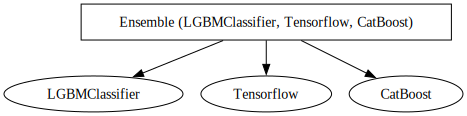

In [22]:
visualize_ensemble_structure(CONFIG_LIBRARY)

# **THESEUS has started**

## **function initialization has started**

MODEL  0  is being initialized
model  0  has children  [1, 2, 3]
	MODEL  1  is being initialized
	MODEL  1  has been initialized
	MODEL  2  is being initialized
	MODEL  2  has been initialized
	MODEL  3  is being initialized
	MODEL  3  has been initialized
MODEL  0  has been initialized


## **function initialization has successfully finished**


initialization() - done in 0s


## **Function fit_models has started**

### **Function train has started - model 0**

### **Function train has started - model 1**

### **Function make_data has started - model 1**

make_data_for_model1 started
target, case_id, and WEEK_NUM are present and properly formatted
target
0.0    6518
1.0     141
NaN      10
Name: count, dtype: int64
Number of columns (excluding 'target', 'case_id', and 'WEEK_NUM'):  300
Number of rows: 6669
make_data_for_model1 ended


### **Function make_data has finished - model 1**

### **Function fit has started - model 1**

Train/valid shape: (6659, 303), 
df train shape  (6659, 300)
y shape  6659


  0%|          | 0/5 [00:00<?, ?it/s]



X_train shape  (5109, 300)
y_train shape  5109
X_valid shape  (1550, 300)
y_valid shape  1550
Training until validation scores don't improve for 100 rounds


 20%|██        | 1/5 [00:03<00:12,  3.08s/it]

[200]	training's auc: 0.999904	valid_1's auc: 0.716594
Early stopping, best iteration is:
[105]	training's auc: 0.996412	valid_1's auc: 0.729094
Fold  1 AUC : 0.729094. Elapsed time: 3.00 seconds. Remaining time: 12.01 seconds.


X_train shape  (5153, 300)
y_train shape  5153
X_valid shape  (1506, 300)
y_valid shape  1506
Training until validation scores don't improve for 100 rounds


 40%|████      | 2/5 [00:05<00:08,  2.87s/it]

Early stopping, best iteration is:
[35]	training's auc: 0.975557	valid_1's auc: 0.790137
Fold  2 AUC : 0.790137. Elapsed time: 5.74 seconds. Remaining time: 8.60 seconds.


X_train shape  (4969, 300)
y_train shape  4969
X_valid shape  (1690, 300)
y_valid shape  1690
Training until validation scores don't improve for 100 rounds


 60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

Early stopping, best iteration is:
[75]	training's auc: 0.987425	valid_1's auc: 0.758951
Fold  3 AUC : 0.758951. Elapsed time: 8.94 seconds. Remaining time: 5.96 seconds.


X_train shape  (5300, 300)
y_train shape  5300
X_valid shape  (1359, 300)
y_valid shape  1359
Training until validation scores don't improve for 100 rounds


 80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

Early stopping, best iteration is:
[22]	training's auc: 0.943255	valid_1's auc: 0.784114
Fold  4 AUC : 0.784114. Elapsed time: 11.52 seconds. Remaining time: 2.88 seconds.


X_train shape  (6105, 300)
y_train shape  6105
X_valid shape  (554, 300)
y_valid shape  554
Training until validation scores don't improve for 100 rounds


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]

Early stopping, best iteration is:
[6]	training's auc: 0.866538	valid_1's auc: 0.72212
Fold  5 AUC : 0.722120. Elapsed time: 14.11 seconds. Remaining time: 0.00 seconds.
Full AUC score 0.738465


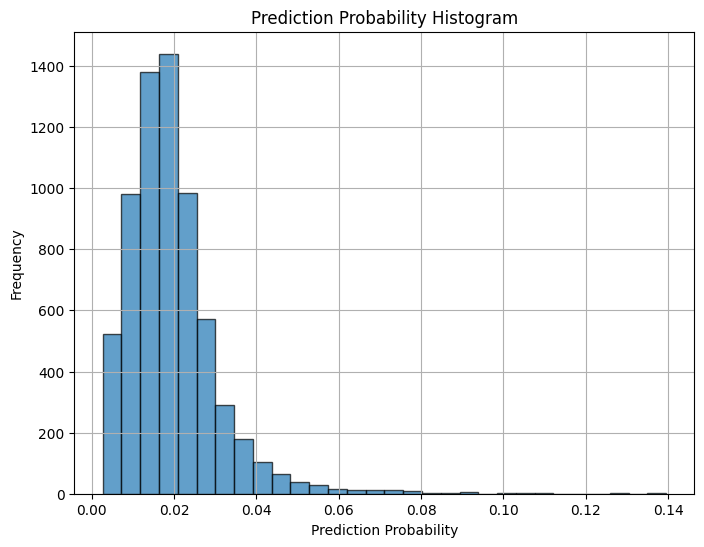

oof_preds shape  (6659,)
data shape  (6659,)
shape oof_df is  (6659, 2)


### **Function fit has finished - model 1**

### **Function make_prediction has started - model 1**

(10,)
case_id
57543    0.022655
57549    0.018010
57551    0.019822
57552    0.022516
57569    0.018935
dtype: float64
oof_preds shape (6659, 2)
output shape (10, 2)
concatenated_dfshape (6669, 2)
merged shape (6669, 4)
      preds  case_id
0  0.022655    57543
1  0.018010    57549
2  0.019822    57551
3  0.022516    57552
4  0.018935    57569


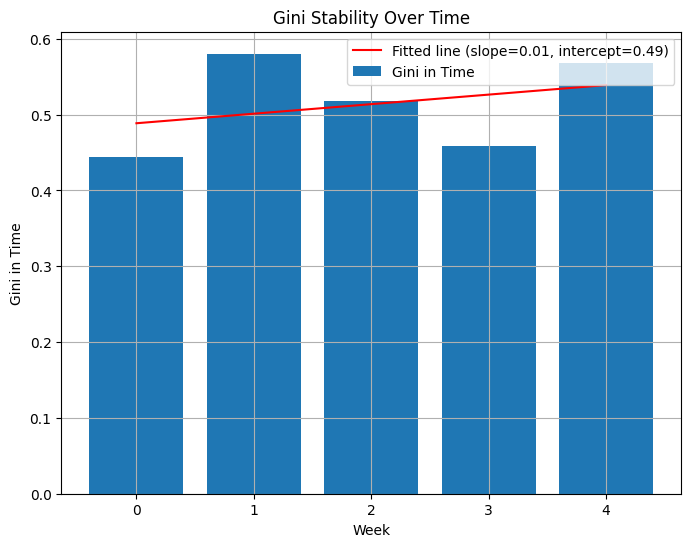

Gini stability - model  1 is  0.48755141105372096


### **Function make_prediction has finished - model 1**

### **Function train has finished - model 1**

### **Function train has started - model 2**

### **Function make_data has started - model 2**

make_data_for_model2 started
target, case_id, and WEEK_NUM are present and properly formatted
target
0.0    6518
1.0     141
NaN      10
Name: count, dtype: int64
Number of columns (excluding 'target', 'case_id', and 'WEEK_NUM'):  300
Number of rows: 6669
make_data_for_model2 ended


### **Function make_data has finished - model 2**

### **Function fit has started - model 2**

first for loop


 50%|█████     | 1/2 [00:00<00:00,  5.68it/s]

3330


100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

3329


second for loop


  0%|          | 0/2 [00:00<?, ?it/s]

FOLD  0
here  1
length  (3329, 300) (3329, 1)
train_x shape:  (3329, 300)
train_y shape:  (3329, 1)
valid_x shape:  (3330, 300)
valid_y shape:  (3330, 1)
Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.






MODEL 1


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,833 (18.88 KB)

 Trainable params: 4,833 (18.88 KB)

 Non-trainable params: 0 (0.00 B)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Optional: Set the correct initial bias.These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see A Recipe for Training Neural Networks: init well. This can help with initial convergence.With the default bias initialization the loss should be about math.log(2) = 0.69314
Loss: 1.2041






MODEL 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Loss: 0.3785












MODEL 5
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - auc: 0.4911 - cross entropy: 0.7325 - loss: 0.6001 - prc: 0.0202 - val_auc: 0.4692 - val_cross entropy: 0.2879 - val_loss: 0.2942 - val_prc: 0.0215
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auc: 0.4188 - cross entropy: 0.4956 - loss: 0.4868 - prc: 0.0183 - val_auc: 0.4764 - val_cross entropy: 0.2312 - val_loss: 0.2368 - val_prc: 0.0218
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auc: 0.4758 - cross entropy: 0.4052 - loss: 0.4005 - prc: 0.0194 - va

 50%|█████     | 1/2 [00:29<00:29, 29.27s/it]

FOLD  1
here  0
length  (3330, 300) (3330, 1)
train_x shape:  (3330, 300)
train_y shape:  (3330, 1)
valid_x shape:  (3329, 300)
valid_y shape:  (3329, 1)
Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.






MODEL 1


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,833 (18.88 KB)

 Trainable params: 4,833 (18.88 KB)

 Non-trainable params: 0 (0.00 B)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Optional: Set the correct initial bias.These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see A Recipe for Training Neural Networks: init well. This can help with initial convergence.With the default bias initialization the loss should be about math.log(2) = 0.69314
Loss: 0.6608






MODEL 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Loss: 0.1109












MODEL 5
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - auc: 0.5667 - cross entropy: 0.2565 - loss: 0.1334 - prc: 0.0258 - val_auc: 0.6049 - val_cross entropy: 0.1049 - val_loss: 0.1050 - val_prc: 0.0297
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - auc: 0.5096 - cross entropy: 0.1327 - loss: 0.1313 - prc: 0.0270 - val_auc: 0.6014 - val_cross entropy: 0.1038 - val_loss: 0.1039 - val_prc: 0.0296
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - auc: 0.5380 - cross entropy: 0.1271 - loss: 0.1258 - prc: 0.0248 - val_

100%|██████████| 2/2 [00:58<00:00, 29.06s/it]

Full AUC score 0.727907
oof_preds shape  (6659,)
data shape  (6659,)
shape oof_df is  (6659, 2)


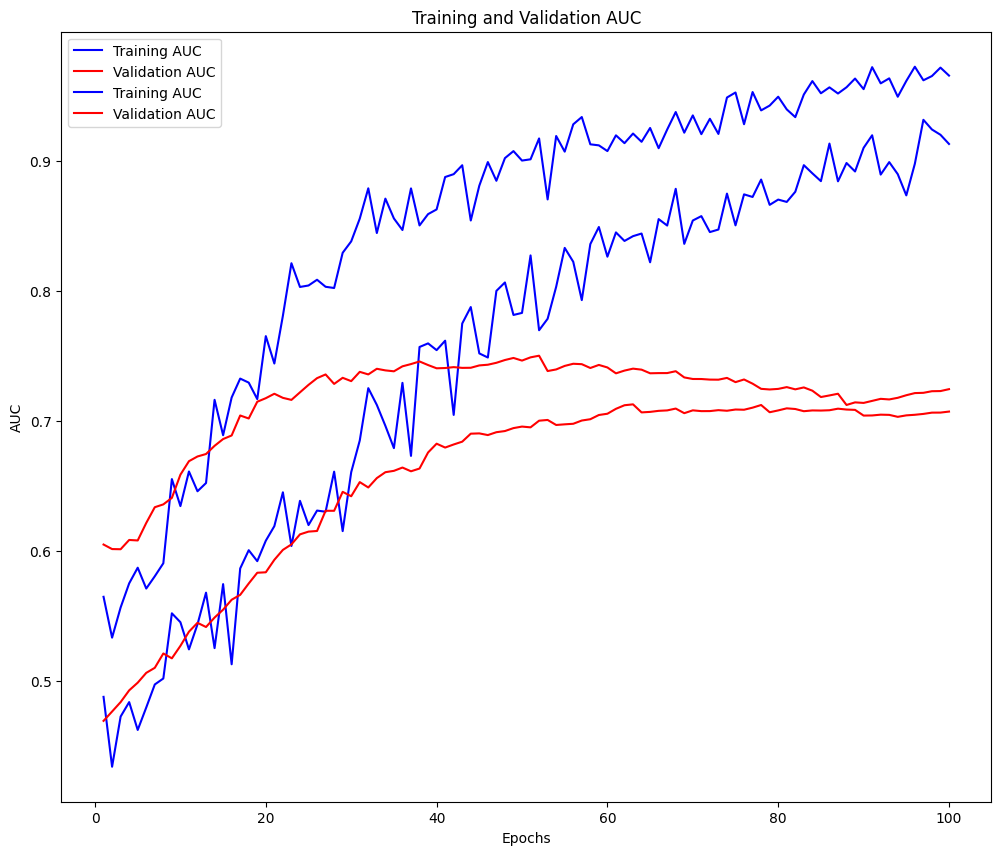

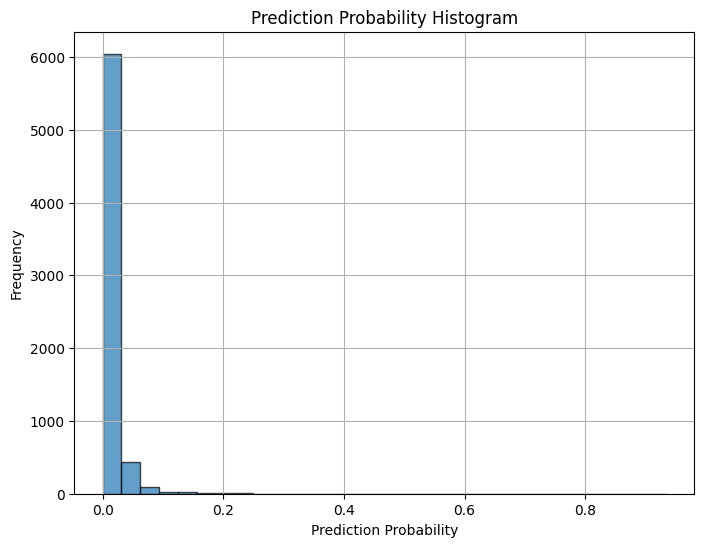

### **Function fit has finished - model 2**

### **Function make_prediction has started - model 2**

Predicting:   0%|          | 0/2 [00:00<?, ? models/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:   0%|          | 0/2 [00:00<?, ? models/s]


(10,)


Predicting:   0%|          | 0/2 [00:00<?, ? models/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:   0%|          | 0/2 [00:00<?, ? models/s]

case_id
57543    0.142870
57549    0.055903
57551    0.035806
57552    0.006505
57569    0.021649
dtype: float32
oof_preds shape (6659, 2)
output shape (10, 2)
concatenated_dfshape (6669, 2)
merged shape (6669, 4)
      preds  case_id
0  0.142870    57543
1  0.055903    57549
2  0.035806    57551
3  0.006505    57552
4  0.021649    57569


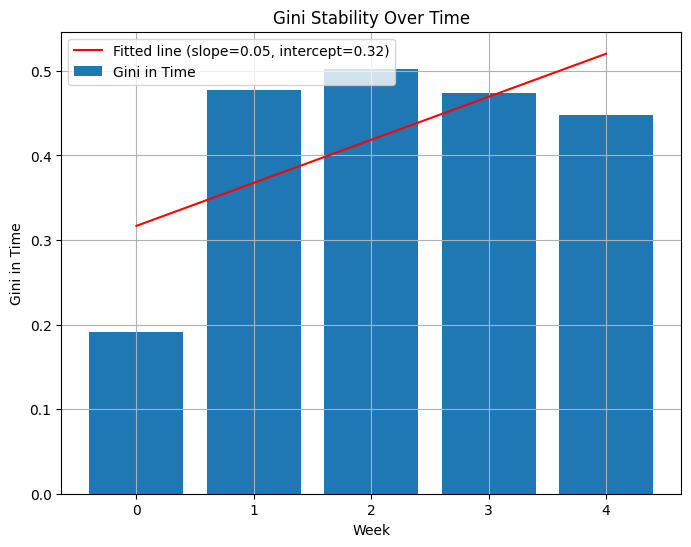

Gini stability - model  2 is  0.3736006098082316


### **Function make_prediction has finished - model 2**

### **Function train has finished - model 2**

### **Function train has started - model 3**

### **Function make_data has started - model 3**

target, case_id, and WEEK_NUM are present and properly formatted
target
0.0    6518
1.0     141
NaN      10
Name: count, dtype: int64
Number of columns (excluding 'target', 'case_id', and 'WEEK_NUM'):  300
Number of rows: 6669
make_data_for_model3 ended


### **Function make_data has finished - model 3**

### **Function fit has started - model 3**

  0%|          | 0/2 [00:00<?, ?it/s]

0:	test: 0.4921357	best: 0.4921357 (0)	total: 317ms	remaining: 10m 34s
100:	test: 0.5723902	best: 0.5750240 (78)	total: 6.69s	remaining: 2m 5s
200:	test: 0.6134732	best: 0.6134732 (200)	total: 13.3s	remaining: 1m 59s
300:	test: 0.6352456	best: 0.6355551 (291)	total: 19.4s	remaining: 1m 49s
400:	test: 0.6404540	best: 0.6411468 (389)	total: 25.5s	remaining: 1m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6411468442
bestIteration = 389

Shrink model to first 390 iterations.


 50%|█████     | 1/2 [00:31<00:31, 31.82s/it]

0:	test: 0.5449649	best: 0.5449649 (0)	total: 60.4ms	remaining: 2m
100:	test: 0.6295899	best: 0.6300911 (99)	total: 6.04s	remaining: 1m 53s
200:	test: 0.6660179	best: 0.6671173 (189)	total: 12.2s	remaining: 1m 49s
300:	test: 0.6822176	best: 0.6822176 (300)	total: 18.6s	remaining: 1m 44s
400:	test: 0.6806132	best: 0.6825478 (311)	total: 24.6s	remaining: 1m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6825478222
bestIteration = 311

Shrink model to first 312 iterations.


100%|██████████| 2/2 [00:57<00:00, 28.85s/it]


Full AUC score 0.659963


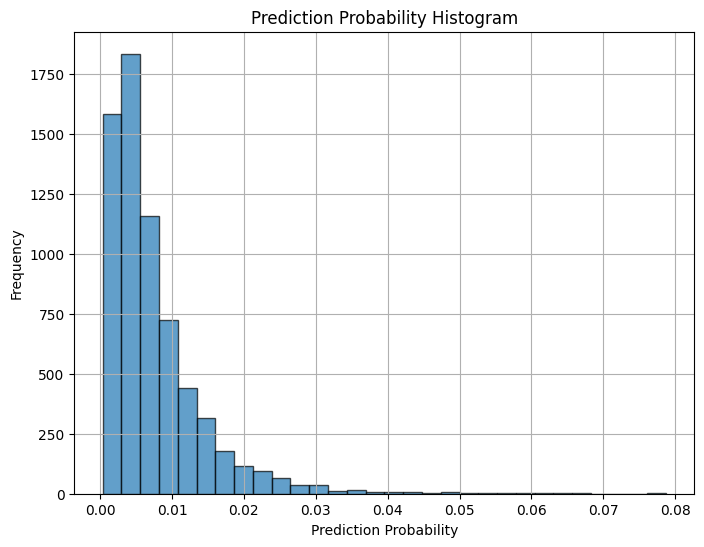

### **Function fit has finished - model 3**

### **Function make_prediction has started - model 3**

(10,)
case_id
57543    0.021292
57549    0.033980
57551    0.014947
57552    0.027274
57569    0.093549
dtype: float64
oof_preds shape (6659, 2)
output shape (10, 2)
concatenated_dfshape (6669, 2)
merged shape (6669, 4)
      preds  case_id
0  0.021292    57543
1  0.033980    57549
2  0.014947    57551
3  0.027274    57552
4  0.093549    57569


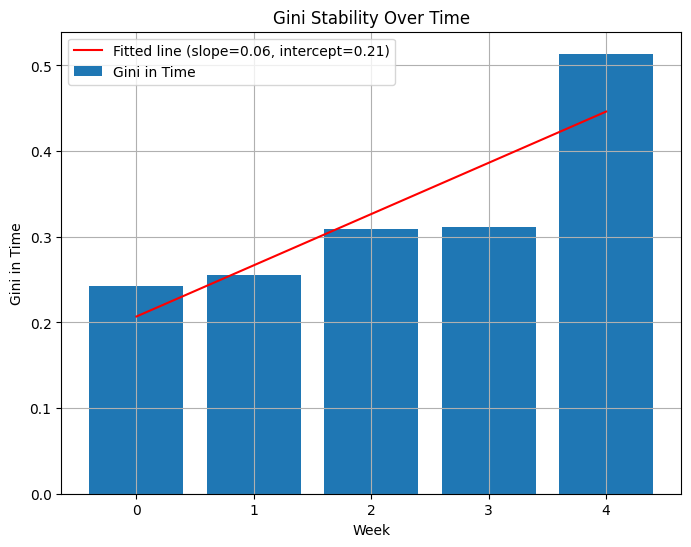

Gini stability - model  3 is  0.3022280913846993


### **Function make_prediction has finished - model 3**

### **Function train has finished - model 3**

All submodels of model  0  have been trained


### **Function make_data has started - model 0**

The 'case_id' columns have the same values and order in both dataframes.
The 'case_id' columns have the same values and order in both dataframes.
Index(['preds', 'case_id', 'WEEK_NUM', 'target'], dtype='object')
Index(['preds', 'case_id', 'WEEK_NUM', 'target'], dtype='object')
merged columns  Index(['preds_df1', 'case_id', 'WEEK_NUM_df1', 'target_df1', 'preds_df2',
       'WEEK_NUM_df2', 'target_df2'],
      dtype='object')
here 1 shape  (6669, 5)
here 2 shape  (6669, 6)
        preds1  case_id  WEEK_NUM  target    preds2    preds3
0     0.021943  2696755        87     0.0  0.023088  0.018832
1     0.017991  2696756        87     0.0  0.000527  0.003116
2     0.024088  2696757        87     0.0  0.003469  0.010989
3     0.022384  2696758        87     0.0  0.008747  0.014130
4     0.018336  2696759        87     0.0  0.000171  0.011018
...        ...      ...       ...     ...       ...       ...
6664  0.021732    57630       100     NaN  0.024293  0.015286
6665  0.017854    57631     

### **Function make_data has finished - model 0**

### **Function fit has started - model 0**

        preds1  case_id    preds2    preds3
0     0.021943  2696755  0.023088  0.018832
1     0.017991  2696756  0.000527  0.003116
2     0.024088  2696757  0.003469  0.010989
3     0.022384  2696758  0.008747  0.014130
4     0.018336  2696759  0.000171  0.011018
...        ...      ...       ...       ...
6654  0.012625  2703450  0.000307  0.003784
6655  0.012806  2703451  0.000287  0.002958
6656  0.030718  2703452  0.041089  0.012402
6657  0.015664  2703453  0.001143  0.018895
6658  0.014513  2703454  0.000966  0.002335

[6659 rows x 4 columns]
Full AUC score 0.770470


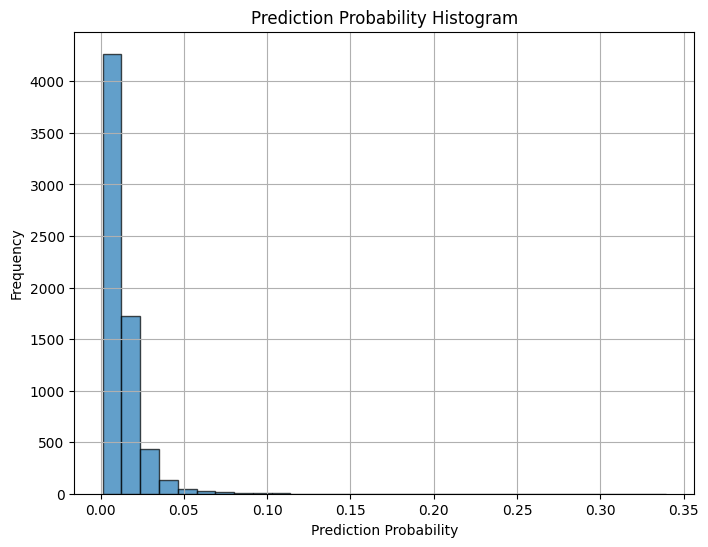

### **Function fit has finished - model 0**

### **Function make_prediction has started - model 0**

(10,)
case_id
57543    0.062272
57549    0.035964
57551    0.023525
57552    0.018765
57569    0.044711
dtype: float64
oof_preds shape (6659, 2)
output shape (10, 2)
concatenated_dfshape (6669, 2)
merged shape (6669, 4)
      preds  case_id
0  0.062272    57543
1  0.035964    57549
2  0.023525    57551
3  0.018765    57552
4  0.044711    57569


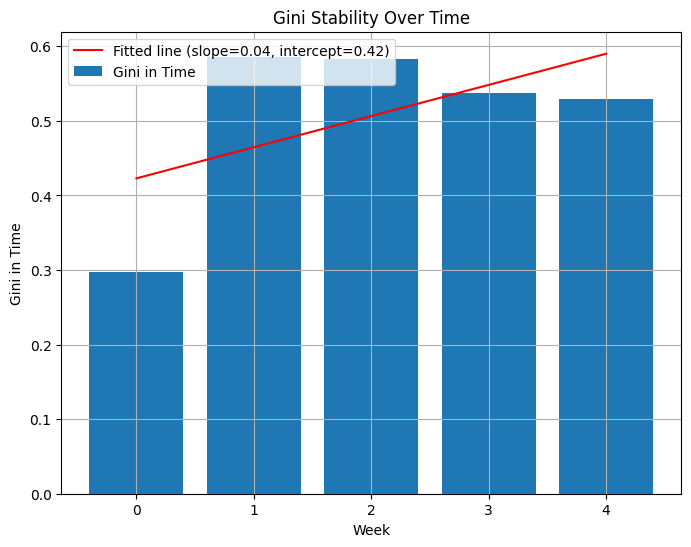

Gini stability - model  0 is  0.4615905014360783


### **Function make_prediction has finished - model 0**

### **Function train has finished - model 0**

## **Function fit_models has finished**

fit_models() - done in 207s


# **THESEUS has successfully finished**

In [23]:
main()